In [37]:
import pandas as pd
import os
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


import numpy as np



In [38]:
import pickle 

with open('opensmile/cnn_model.pkl', 'rb') as file:
    model = pickle.load(file)


In [39]:


with open('cnn_model2.pkl', 'rb') as file:
    model2 = pickle.load(file)


In [40]:
crema_data = pd.read_csv('merged_crema_df.csv')

In [41]:


ravdess_data = pd.read_csv('opensmile/ravdess_features.csv')

In [42]:
X = crema_data.drop(columns=['filename', 'Emotion', 'Audio', 'Text'])
y = crema_data['Emotion']  

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_reshaped = np.expand_dims(X_scaled, axis=-1)

predictions = model2.predict(X_reshaped)


233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [43]:
for i in range(3):
    print(predictions[i])

[7.4801475e-02 1.1640916e-11 5.9265442e-08 2.9643522e-07 9.2519784e-01
 7.0983075e-14 2.3802409e-07 6.5893273e-09]
[3.0454484e-01 7.0277863e-04 5.4296142e-01 5.1476044e-04 3.7123442e-02
 8.7637036e-06 1.0845455e-01 5.6894412e-03]
[8.2743792e-03 8.5259831e-01 2.7586890e-03 5.8310732e-02 6.3331723e-03
 5.3412830e-03 6.6303574e-02 7.9834303e-05]


In [44]:
emotions = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]

mapped_emotions = []
for prediction in predictions:
    one_hot = np.zeros_like(prediction)
    one_hot[np.argmax(prediction)] = 1

    max_index = np.argmax(one_hot)
    emotion = emotions[max_index]
    mapped_emotions.append(emotion)
for i, emotion in enumerate(mapped_emotions):
    print(f"Prediction {i + 1}: {emotion}")

Prediction 1: angry
Prediction 2: happy
Prediction 3: calm
Prediction 4: surprised
Prediction 5: disgust
Prediction 6: happy
Prediction 7: disgust
Prediction 8: disgust
Prediction 9: happy
Prediction 10: neutral
Prediction 11: angry
Prediction 12: calm
Prediction 13: disgust
Prediction 14: sad
Prediction 15: disgust
Prediction 16: disgust
Prediction 17: calm
Prediction 18: angry
Prediction 19: sad
Prediction 20: happy
Prediction 21: happy
Prediction 22: neutral
Prediction 23: angry
Prediction 24: disgust
Prediction 25: happy
Prediction 26: sad
Prediction 27: happy
Prediction 28: disgust
Prediction 29: disgust
Prediction 30: angry
Prediction 31: happy
Prediction 32: happy
Prediction 33: angry
Prediction 34: sad
Prediction 35: neutral
Prediction 36: angry
Prediction 37: sad
Prediction 38: angry
Prediction 39: neutral
Prediction 40: sad
Prediction 41: angry
Prediction 42: angry
Prediction 43: neutral
Prediction 44: happy
Prediction 45: angry
Prediction 46: sad
Prediction 47: sad
Predictio

In [45]:
y.value_counts()

Emotion
Anger        1271
Disgust      1271
Fear         1271
Sad          1271
Happy/Joy    1271
Neutral      1087
Name: count, dtype: int64

In [46]:
X['preds'] = mapped_emotions
X['preds'].value_counts()

preds
happy        2039
angry        1532
disgust       894
neutral       861
calm          821
sad           632
surprised     497
fearful       166
Name: count, dtype: int64

In [47]:
import torch

from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained("Minej/bert-base-personality")
model = BertForSequenceClassification.from_pretrained("Minej/bert-base-personality")

def personality_detection(text):


    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt")
    outputs = model(**inputs)
    predictions = outputs.logits.squeeze().detach().numpy()

    label_names = ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']
    result = {label_names[i]: predictions[i] for i in range(len(label_names))}

    return result,


text_input = "I am feeling excited about the upcoming event."
personality_prediction = personality_detection(text_input)

print(personality_prediction)



({'Extroversion': np.float32(-0.22555107), 'Neuroticism': np.float32(0.053769667), 'Agreeableness': np.float32(0.029500064), 'Conscientiousness': np.float32(-0.45302987), 'Openness': np.float32(-0.44577113)},)


In [48]:
crema_data['Big5'] = crema_data['Text'].apply(personality_detection)

In [49]:
crema_data['ListBig5'] = crema_data['Big5'].apply(lambda d: list(d[0].values()) if isinstance(d, tuple) else [])


In [50]:
crema_data['ListBig5'].head()

0    [-0.56309927, 0.20623396, -0.21064746, -0.7585...
1    [-0.56309927, 0.20623396, -0.21064746, -0.7585...
2    [-0.56309927, 0.20623396, -0.21064746, -0.7585...
3    [-0.56309927, 0.20623396, -0.21064746, -0.7585...
4    [-0.3477254, 0.2361491, -0.14641154, -0.835221...
Name: ListBig5, dtype: object

In [51]:
predictions_df = pd.DataFrame(predictions)

predictions_df['cnn_predictions'] = predictions_df.apply(lambda row: row.tolist(), axis=1)

crema_data['cnn_predictions'] = predictions_df['cnn_predictions']


In [52]:
crema_data['cnn_predictions'].head()

0    [0.0748014748096466, 1.164091566197012e-11, 5....
1    [0.3045448362827301, 0.0007027786341495812, 0....
2    [0.008274379186332226, 0.8525983095169067, 0.0...
3    [3.6802186514250934e-05, 0.0001809606037568301...
4    [0.00046919917804189026, 0.004816995467990637,...
Name: cnn_predictions, dtype: object

In [53]:
crema_data['combined_vector'] = crema_data.apply(lambda row: row['ListBig5'] + row['cnn_predictions'], axis=1)

In [54]:
def assign_mbti_label_balanced(vector):
    # Split the vector into Big Five and emotion scores
    big_five = vector[:5]
    emotions = vector[5:]
    emotion_labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]

    # Normalize Big Five traits logarithmically
    big_five = np.log(np.array(big_five) + 1) / np.log(2)  # Normalize to [0, 1]

    # Extract normalized Big Five traits
    extraversion, agreeableness, conscientiousness, neuroticism, openness = big_five

    # Dynamic thresholds based on median
    sn_threshold = np.median(big_five)  # Dynamic threshold for S/N
    jp_threshold = np.median(big_five)  # Dynamic threshold for J/P

    # Base MBTI from Big Five
    ei = 'E' if extraversion > 0.5 else 'I'
    sn = 'N' if openness > sn_threshold else 'S'
    tf = 'F' if agreeableness > 0.5 else 'T'
    jp = 'J' if conscientiousness > jp_threshold else 'P'

    # Determine dominant emotion
    dominant_emotion_index = emotions.index(max(emotions))
    dominant_emotion = emotion_labels[dominant_emotion_index]

    # Adjust MBTI based on the dominant emotion
    if dominant_emotion in ["happy", "surprised"]:
        ei = 'E'
    elif dominant_emotion in ["sad", "calm", "fearful"]:
        ei = 'I'

    if dominant_emotion in ["angry", "disgust"]:
        tf = 'T'
    elif dominant_emotion in ["neutral", "happy"]:
        tf = 'F'

    sn = 'N' if openness > sn_threshold else 'S'
    jp = 'J' if conscientiousness > jp_threshold else 'P'

    # Return the final MBTI label
    return ei + sn + tf + jp


In [55]:
# crema_data['ground_truths'] = crema_data['combined_vector'].apply(assign_mbti_label)

crema_data['ground_truths_balanced'] = crema_data['combined_vector'].apply(assign_mbti_label_balanced)

In [56]:
crema_data['ground_truths_balanced'].value_counts()

ground_truths_balanced
ISTJ    2216
INTP    1829
ENFP    1064
ESFJ     975
INFP     491
ISFJ     370
ENTP     250
ESTJ     247
Name: count, dtype: int64

In [57]:
def logarithmic_normalization(vector):
    big_five = vector[:5]
    emotions = vector[5:]

    big_five = np.log(np.array(big_five) + 1) / np.log(2)
    emotions = np.log(np.array(emotions) + 1) / np.log(2)

    return np.concatenate((big_five, emotions))


In [58]:
crema_data['normalized_combined_vector'] = crema_data['combined_vector'].apply(logarithmic_normalization)

In [59]:
# crema_extracted_df = crema_data[['ListBig5', 'cnn_predictions', 'combined_vector', 'ground_truths', 'ground_truths_balanced', 'normalized_combined_vector']]

crema_extracted_df = crema_data[['ListBig5', 'cnn_predictions', 'combined_vector', 'ground_truths_balanced', 'normalized_combined_vector']]

In [60]:
crema_extracted_df.shape

(7442, 5)

In [61]:

crema_extracted_df.to_csv('crema_extracted_df.csv', index=False)


In [63]:
crema_extracted_df['ground_truths_balanced'].value_counts()

ground_truths_balanced
ISTJ    2216
INTP    1829
ENFP    1064
ESFJ     975
INFP     491
ISFJ     370
ENTP     250
ESTJ     247
Name: count, dtype: int64

In [64]:
crema_extracted_df['ground_truths_balanced'].value_counts()

ground_truths_balanced
ISTJ    2216
INTP    1829
ENFP    1064
ESFJ     975
INFP     491
ISFJ     370
ENTP     250
ESTJ     247
Name: count, dtype: int64

In [65]:
crema_model_df = pd.read_csv('crema_extracted_df.csv')

In [66]:
crema_model_df

,ListBig5,cnn_predictions,combined_vector,ground_truths_balanced,normalized_combined_vector
0,"[np.float32(-0.56309927), np.float32(0.2062339...","[0.0748014748096466, 1.164091566197012e-11, 5....","[np.float32(-0.56309927), np.float32(0.2062339...",ISTJ,[-1.19462262e+00 2.70509792e-01 -3.41258338e-...
1,"[np.float32(-0.56309927), np.float32(0.2062339...","[0.3045448362827301, 0.0007027786341495812, 0....","[np.float32(-0.56309927), np.float32(0.2062339...",ESFJ,[-1.19462262e+00 2.70509792e-01 -3.41258338e-...
2,"[np.float32(-0.56309927), np.float32(0.2062339...","[0.008274379186332226, 0.8525983095169067, 0.0...","[np.float32(-0.56309927), np.float32(0.2062339...",ISTJ,[-1.19462262e+00 2.70509792e-01 -3.41258338e-...
3,"[np.float32(-0.56309927), np.float32(0.2062339...","[3.6802186514250934e-05, 0.0001809606037568301...","[np.float32(-0.56309927), np.float32(0.2062339...",ESTJ,[-1.19462262e+00 2.70509792e-01 -3.41258338e-...
4,"[np.float32(-0.3477254), np.float32(0.2361491)...","[0.00046919917804189026, 0.004816995467990637,...","[np.float32(-0.3477254), np.float32(0.2361491)...",ISTJ,[-6.16448637e-01 3.05852721e-01 -2.28387414e-...
...,...,...,...,...,...
7437,"[np.float32(-0.2719124), np.float32(0.22109346...","[0.2761523127555847, 1.9205801879418338e-11, 0...","[np.float32(-0.2719124), np.float32(0.22109346...",INTP,[-4.57816054e-01 2.88173571e-01 -2.25697541e-...
7438,"[np.float32(-0.70187056), np.float32(0.2120521...","[0.05294669792056084, 1.84564127869713e-10, 0....","[np.float32(-0.70187056), np.float32(0.2120521...",ISTJ,[-1.74598920e+00 2.77451721e-01 -3.10274201e-...
7439,"[np.float32(-0.70187056), np.float32(0.2120521...","[0.2540688216686249, 3.901179752574535e-06, 0....","[np.float32(-0.70187056), np.float32(0.2120521...",ISTJ,[-1.74598920e+00 2.77451721e-01 -3.10274201e-...
7440,"[np.float32(-0.2292771), np.float32(0.20114774...","[0.9782660603523254, 1.35023879010987e-06, 0.0...","[np.float32(-0.2292771), np.float32(0.20114774...",ISFJ,[-3.75715922e-01 2.64413673e-01 -3.16620576e-...


In [67]:
ffn_df = crema_model_df[['normalized_combined_vector', 'ground_truths_balanced']]

In [68]:
ffn_df

,normalized_combined_vector,ground_truths_balanced
0,[-1.19462262e+00 2.70509792e-01 -3.41258338e-...,ISTJ
1,[-1.19462262e+00 2.70509792e-01 -3.41258338e-...,ESFJ
2,[-1.19462262e+00 2.70509792e-01 -3.41258338e-...,ISTJ
3,[-1.19462262e+00 2.70509792e-01 -3.41258338e-...,ESTJ
4,[-6.16448637e-01 3.05852721e-01 -2.28387414e-...,ISTJ
...,...,...
7437,[-4.57816054e-01 2.88173571e-01 -2.25697541e-...,INTP
7438,[-1.74598920e+00 2.77451721e-01 -3.10274201e-...,ISTJ
7439,[-1.74598920e+00 2.77451721e-01 -3.10274201e-...,ISTJ
7440,[-3.75715922e-01 2.64413673e-01 -3.16620576e-...,ISFJ


In [69]:
import torch
import pandas as pd

def parse_array_string(s):
    # Remove square brackets and replace newlines with spaces
    s = s.strip('[]').replace('\n', ' ')
    # Split the string into individual elements
    items = s.split()
    # Convert each element to float
    float_items = [float(item) for item in items]
    # Convert the list to a PyTorch tensor
    return torch.tensor(float_items, dtype=torch.float32)

# Apply the function to the DataFrame column
ffn_df['normalized_combined_vector'] = ffn_df['normalized_combined_vector'].apply(parse_array_string)

# Verify the result
print(ffn_df['normalized_combined_vector'].iloc[0])
print(type(ffn_df['normalized_combined_vector'].iloc[0]))


tensor([-1.1946e+00,  2.7051e-01, -3.4126e-01, -2.0500e+00, -4.9066e-01,
         1.0407e-01,  1.6794e-11,  8.5502e-08,  4.2767e-07,  9.4501e-01,
         1.0251e-13,  3.4340e-07,  9.5064e-09])
<class 'torch.Tensor'>


C:\Users\anany\AppData\Local\Temp\ipykernel_3728\1195514629.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ffn_df['normalized_combined_vector'] = ffn_df['normalized_combined_vector'].apply(parse_array_string)


In [70]:
ffn_df['ground_truths_balanced'] = ffn_df['ground_truths_balanced'].astype('category')
ffn_df['label_codes'] = ffn_df['ground_truths_balanced'].cat.codes

C:\Users\anany\AppData\Local\Temp\ipykernel_3728\3826440649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ffn_df['ground_truths_balanced'] = ffn_df['ground_truths_balanced'].astype('category')
C:\Users\anany\AppData\Local\Temp\ipykernel_3728\3826440649.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ffn_df['label_codes'] = ffn_df['ground_truths_balanced'].cat.codes


In [72]:
print(ffn_df[['ground_truths_balanced', 'label_codes']].head())

  ground_truths_balanced  label_codes
0                   ISTJ            7
1                   ESFJ            2
2                   ISTJ            7
3                   ESTJ            3
4                   ISTJ            7


In [73]:
from torch.utils.data import Dataset

class PersonalityDataset(Dataset):
    def __init__(self, dataframe):
        self.vectors = dataframe['normalized_combined_vector'].tolist()  # List of tensors
        self.labels = torch.tensor(dataframe['label_codes'].tolist(), dtype=torch.long)  # Numeric labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.vectors[idx], self.labels[idx]

# Create the dataset
dataset = PersonalityDataset(ffn_df)

# Verify a sample
print(dataset[0])


(tensor([-1.1946e+00,  2.7051e-01, -3.4126e-01, -2.0500e+00, -4.9066e-01,
         1.0407e-01,  1.6794e-11,  8.5502e-08,  4.2767e-07,  9.4501e-01,
         1.0251e-13,  3.4340e-07,  9.5064e-09]), tensor(7))


In [74]:
from sklearn.model_selection import train_test_split

# Split the DataFrame
train_df, test_df = train_test_split(ffn_df, test_size=0.2, random_state=42)

# Create train and test datasets
train_dataset = PersonalityDataset(train_df)
test_dataset = PersonalityDataset(test_df)


In [75]:
from torch.utils.data import DataLoader

batch_size = 64

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class FFN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(13, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 8)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


In [77]:
feedforward_net = FFN()
criterion = nn.CrossEntropyLoss()
optimizer_ffn = torch.optim.Adam(feedforward_net.parameters(), lr=0.001)


loss_values_ffn = []   # loss for each epoch 


num_epochs_ffn = 25

for epoch in range(num_epochs_ffn):  # loop over the dataset multiple times
    running_loss_ffn = 0.0

    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Flatten inputs for ffn
        inputs = inputs.flatten(start_dim=1)
        
        # zero the parameter gradients
        optimizer_ffn.zero_grad()

        # forward + backward + optimize
        outputs = feedforward_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_ffn.step()
        running_loss_ffn += loss.item()
    loss_values_ffn.append(running_loss_ffn)    

    print(f"Training loss: {running_loss_ffn}")

print('Finished Training')

torch.save(feedforward_net.state_dict(), 'ffn.pth')  # Saves model file (upload with submission)

with open('loss_values_ffn.pkl', 'wb') as f:
    pickle.dump(loss_values_ffn, f)


Training loss: 110.69126529246569
Training loss: 29.61620471253991
Training loss: 15.443618841469288
Training loss: 11.490172120073112
Training loss: 9.077613550165552
Training loss: 8.268560404889286
Training loss: 7.492075614631176
Training loss: 7.0923188219967415
Training loss: 7.1212458138979855
Training loss: 7.089912637136877
Training loss: 7.506302037221758
Training loss: 6.405068176785335
Training loss: 6.095285221505037
Training loss: 6.137977506878087
Training loss: 5.910950147052063
Training loss: 5.845061766944127
Training loss: 5.626537035218121
Training loss: 5.616374940145761
Training loss: 5.33619090816137
Training loss: 5.9178667454780225
Training loss: 5.166653404099634
Training loss: 5.049183038063347
Training loss: 5.423826803918928
Training loss: 7.407801338470904
Training loss: 4.846275336443796
Finished Training


In [78]:

feedforward_net.load_state_dict(torch.load('ffn.pth'))

correct_ffn = 0
total_ffn = 0

with torch.no_grad():           # since we're not training, we don't need to calculate the gradients for our outputs
    for data in test_loader:
        inputs, labels = data
        inputs_flattened = inputs.flatten(start_dim=1)

        outputs_ffn = feedforward_net(inputs_flattened)
        correct_ffn += (torch.argmax(outputs_ffn, dim=1) == labels).sum().item()
        total_ffn += labels.size(0)


print('Accuracy for feedforward network: ', correct_ffn/total_ffn)


Accuracy for feedforward network:  0.9630624580255205


C:\Users\anany\AppData\Local\Temp\ipykernel_3728\2475985371.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feedforward_net.load_state_dict(torch.load('ffn.pth'))


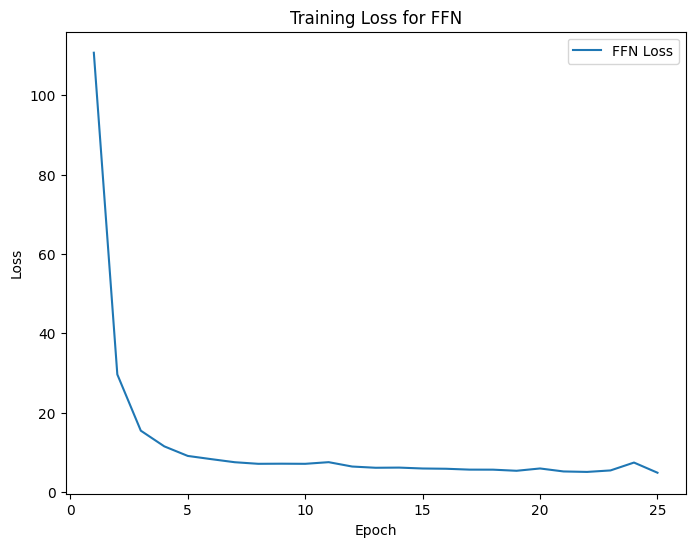

In [79]:
import matplotlib.pyplot as plt
import pickle



def plot_loss(loss_history, model):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(loss_history) + 1), loss_history, label=f"{model} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training Loss for {model}")
    plt.legend()
    plt.savefig('loss_char_' + model + '.png') 
    plt.show()


with open('loss_values_ffn.pkl', 'rb') as f:
    loss_values_ffn = pickle.load(f)


plot_loss(loss_values_ffn, "FFN")